In [2]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *

In [28]:

main_path = '/data/xiaowei/social_network/HENU/'
def draw_topo(folder_name,main_path,model_type):
    epoch = loadpkl(main_path + 'preprocessing/' + folder_name + '/final_eye_close_1001_epoch_concat.pkl')
    psd_r2_path = main_path + 'EEG_regression/' + folder_name + f'/{model_type}_r2_score.csv'
    psd_r2 = pd.read_csv(psd_r2_path, index_col=0, header=0)
    evoke = epoch['T'].copy().average()

    fig = plt.figure(figsize=(32, 10))
    fig.suptitle(f'{folder_name} {model_type}', fontsize=20)
    axes = {}
    key_index_list = ['final_eye_close_PSD_CH','final_eye_open_PSD_CH','midterm_eye_close_PSD_CH','midterm_eye_open_PSD_CH']
    for i, key_index in enumerate(key_index_list):
        plt.subplot(1,len(key_index_list), i+1)
        evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
        mne.viz.plot_topomap(data =  np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]),
                             pos = epoch.info,
                             names = epoch.info['ch_names'],show_names = True,
                             vmin = 0.35,
                             vmax = 0.5,
                             cmap = 'jet',show = False,
                             )
        plt.title(key_index, fontdict={'fontsize': 30})


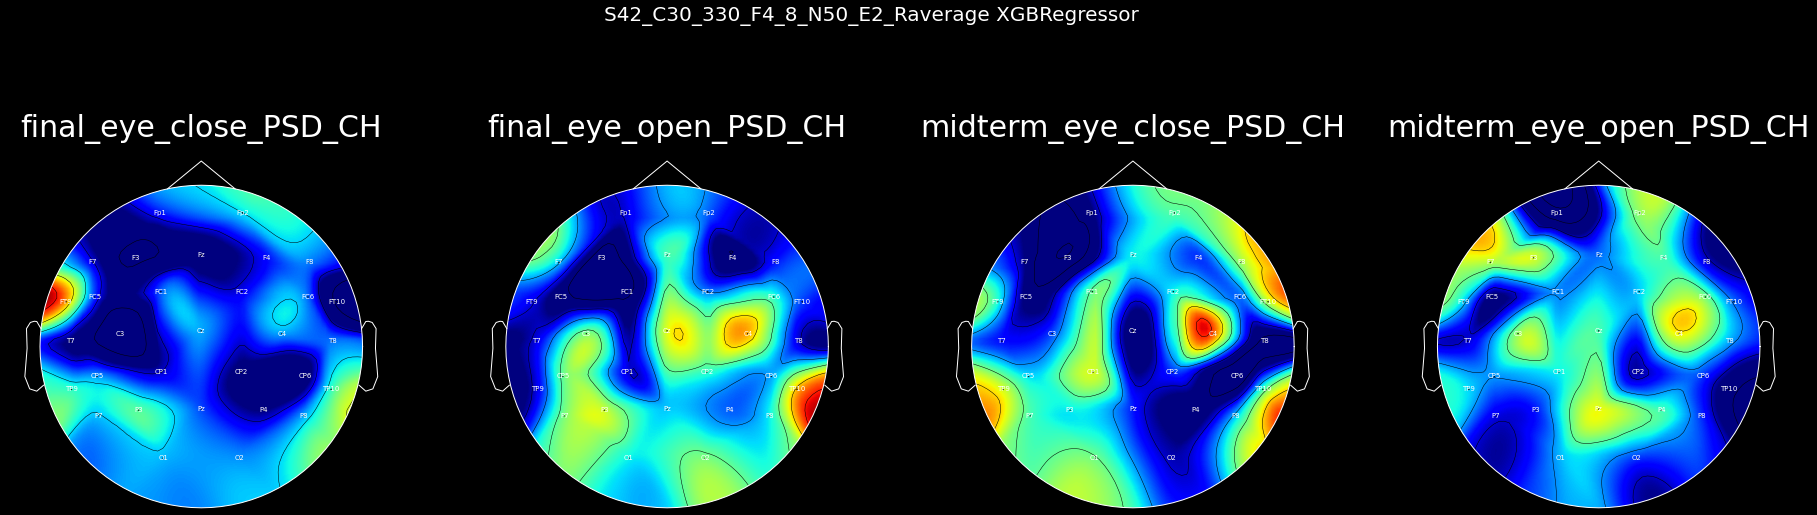

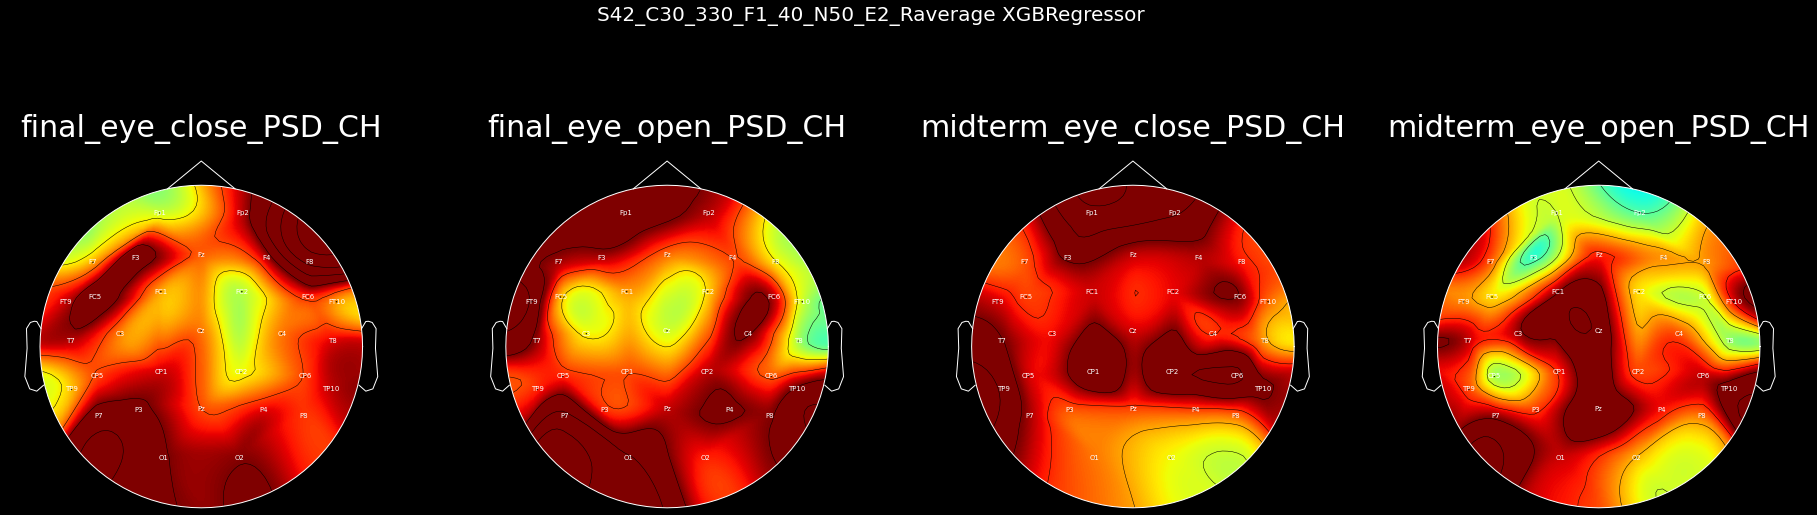

In [37]:
draw_topo(folder_name = 'S42_C30_330_F4_8_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'S42_C30_330_F14_30_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
draw_topo(folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'C30_330_F8_14_N50_E1.5_Raverage',main_path = main_path,model_type = 'XGBRegressor')
# draw_topo(folder_name = 'C30_330_F8_14_N50_E1_Raverage',main_path = main_path,model_type = 'XGBRegressor')


In [31]:
df = pd.read_excel('/data/xiaowei/social_network/HENU/data/survey_data/Social_network_V2.xlsx', index_col=0, header=0)

a = df.to_numpy().reshape(-1)

from sklearn.metrics import r2_score
import torch
print(np.unique(a, return_counts=True))
r2 = r2_score(a, np.ones_like(a)*a.mean())
print(r2)
print(1262/np.sum(np.unique(a, return_counts=True)[1]))


(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1262,  203,  140,  193,  307,  352,  343,  170,   54]))
0.0
0.4173280423280423


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


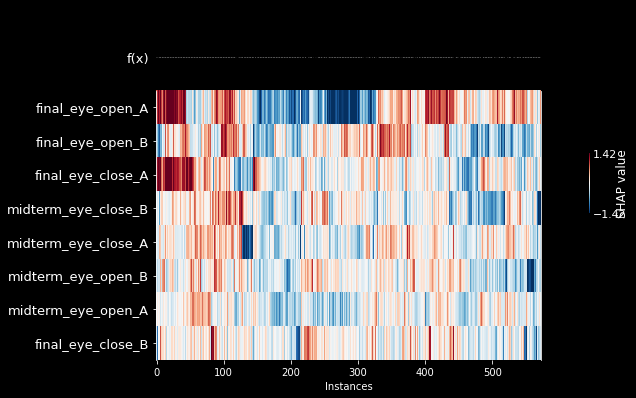

In [18]:
import shap
shap.initjs()
# {'model':model,'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test,'X_name':X_name}
folder_name = 'S42_C30_330_F8_14_N50_E2_Raverage'
model_type = 'xgboost'

model_set = loadpkl(main_path + 'statistic/alpha_asymmetry'  + f'/{folder_name}_{model_type}_set_model.pkl')
explainer = shap.Explainer(model_set['model'],feature_names=model_set['X_name'][1:])
shap_values = explainer(model_set['X_test'])
shap.plots.heatmap(shap_values,cmap = 'RdBu_r')